In [35]:
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
plt.style.use('fivethirtyeight')
import pymc as pm
import seaborn as sns
import arviz as az
from statsmodels.graphics.tsaplots import plot_acf

# <font face="gotham" color="orange"> Simple Linear Regression</font>

This is a simple linear regression model as in every textbooks
$$
Y_i=\beta_1+\beta_2X_i+u_i\qquad i = 1, 2, ..., n
$$
where $Y$ is **dependent variable**, $X$ is **independent variable** and $u$ is **disturbance term**. $\beta_1$ and $\beta_2$ are unknown parameters that we are aiming to estimate by feeding the data in the model. 

Following Gauss-Markov assumptions,
$$
E(Y|X_i) = {\beta}_1 + {\beta}_2X_i\\
Y_{i} \sim \mathrm{N}\left({\beta_{1}}+{\beta_{2}}X_{i}, \sigma^{2}\right)
$$
Similarly, the **precision** parameter $h$ is defined as the inverse of variance $\sigma^2$, i.e.  $h=\frac{1}{\sigma^2}$.

## <font face="gotham" color="orange"> The Priors</font>

Each of these three parameters, i.e. $\beta_1$, $\beta_2$ and $h$ will be estimated, therefore each of them have their own **prior elicitation** which means defining a prior with all proper knowledge available. For demonstration purpose, we define $\beta$ priors as normal distributions, however in many case, $\beta$ and $h$ are modeled together with a joint distribution. 

$$
P(\beta_1)=(2 \pi)^{-\frac{1}{2}} h_1^{\frac{1}{2}} \exp{\left(-\frac{1}{2} h_1 \left(\beta_1-\mu_1\right)^{2}\right)}\\
P(\beta_2)=(2 \pi)^{-\frac{1}{2}} h_2^{\frac{1}{2}} \exp{\left(-\frac{1}{2} h_2 \left(\beta_1-\mu_1\right)^{2}\right)}\\
$$

However the $h$ can't be negative, therefore a Gamma distribution would be appropriate. The posterior of $h$ will follow a Gamma distribution too due to **Gamma-Normal conjugate**.
$$
P(h)=\frac{\theta_{0}^{\alpha_{0}} h^{\alpha_{0}-1} e^{-\theta_{0} h}}{\Gamma\left(\alpha_{0}\right)} \quad 0 \leq h \leq \infty
$$

## <font face="gotham" color="orange"> Likelihood Function</font>

With normality assumption, likelihood of $Y$ is
$$
\mathcal{L}\left(Y | \mu_{i}, \sigma^{2}\right)=\prod_{i=1}^n\frac{1}{\sigma \sqrt{2 \pi}} \exp{\left(-\frac{1}{2}\left(\frac{Y_i-\mu_i}{\sigma}\right)^{2}\right)}
$$

Equivalently, replace $\sigma$ by $h$ and rewrite the function into summation
$$
\mathcal{L}\left(Y | \mu_{i}, h\right)=(2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}} \exp{\left(-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-\mu_{i}\right)^{2}\right)}
$$

Replace $\mu_i$ by ${\beta}_1 + {\beta}_2X_i$, note how we have change the notation of parameters
$$
\mathcal{L}\left(Y | \beta_1, \beta_2, h\right)=(2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}} \exp{\left(-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-({\beta}_1 + {\beta}_2X_i)\right)^{2}\right)}
$$

The likelihood function are the same for $\beta_1$, $\beta_2$ and $h$.
$$
\mathcal{L}\left(Y | \beta_1\right)=\mathcal{L}\left(Y | \beta_2\right)=\mathcal{L}\left(Y | h\right)=(2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}} \exp{\left(-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-({\beta}_1 + {\beta}_2X_i)\right)^{2}\right)}
$$

## <font face="gotham" color="orange"> The Posteriors </font>

Be careful about the notation, $h_1$ is the precision of $\beta_1$ which is a variable rather than a constant viewed in frequentists. 

To start from $\beta_1$
$$
P\left(\beta_{1}\right) \times P\left(Y\mid \beta_{1}\right)=(2 \pi)^{-\frac{1}{2}} h_{1}^{\frac{1}{2}} \exp\left({-\frac{h_{1}}{2}\left(\beta_{1}-\mu_{1}\right)^{2}}\right) \times (2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}} \exp{\left(-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-({\beta}_1 + {\beta}_2X_i)\right)^{2}\right)}
$$

Join terms
$$
P\left(\beta_{1}\right) \times P\left(Y\mid \beta_{1}\right)=(2 \pi)^{-\frac{n+1}{2}} h_{1}^{\frac{1}{2}} h^{\frac{n}{2}} \exp{\left(-\frac{1}{2} h_{1}\left(\beta_{1}-\mu_{1}\right)^{2}-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-\beta_{1}-\beta_{2} X_{i}\right)^{2}\right)}
$$

Let's focus on exponential term for now, expand the brackets
\begin{align}
&\exp{\left(-\frac{1}{2} h_{1}\left(\beta_{1}-\mu_{1}\right)^{2}-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-\beta_{1}-\beta_{2} X_{i}\right)^{2}\right)}\\
&= \exp{\left[-\frac{1}{2} h_{1}\left(\beta_{1}^{2}-2 \beta_{1} \mu_{1}+\mu_{1}^{2}\right)-\frac{1}{2} h\left(n \beta_{1}^{2}-2 \beta_{1} \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)+\sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)^{2}\right)\right]}\\
&=\exp{\left[-\frac{1}{2}\left(h_{1}+n h\right) \beta_{1}^{2}-\frac{1}{2}\left[-2 h_{1} \mu_{1}-2 h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right] \beta_{1}-\frac{1}{2} h_{1} \mu_{1}^{2}-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)^{2}\right]}\\
&=\exp{\left[-\frac{1}{2}\left(h_{1}+n h\right) \beta_{1}^{2}+\left[h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right] \beta_{1}+\frac{-\frac{1}{2}\left[h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right]^{2}}{h_{1}+n h}-\frac{-\frac{1}{2}\left[h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right]^{2}}{h_{1}+n h}-\frac{1}{2} h_{1} \mu_{1}^{2}-\frac{1}{2} h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)^{2}\right]}\\
\end{align}
The first three terms can be combined and the rest are free of $\beta_1$, which will be denoted as $C$.

$$
-\frac{1}{2} \left(h_{1}+n h\right)\left[\beta_{1}-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\right]^{2}
$$

Back to Bayes' Theorem
$$
P\left(\beta_{1} | Y\right)=\frac{(2 \pi)^{-\frac{n+1}{2}} h_{1}^{\frac{1}{2}} h^{\frac{n}{2}} \exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[\beta_{1}-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}+C\right]}}{\int_{-\infty}^{\infty}(2 \pi)^{-\frac{n+1}{2}} h_{1}^{\frac{1}{2}} h^{\frac{n}{2}} \exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[u-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}+C\right]} d u}
$$

Cancel out terms, we obtain
$$
P\left(\beta_{1} | Y\right)=\frac{\exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[\beta_{1}-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}\right]}}{\int_{-\infty}^{\infty} \exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[u-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}\right]} d u}
$$

Now multiply both numerator and denominator by
$$
\frac{\sqrt{h_{1}+n h}}{\sqrt{2 \pi}}
$$
which yields

$$
P\left(\beta_{1} | Y\right)=\frac{\frac{\sqrt{h_{1}+n h}}{\sqrt{2 \pi}}\exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[\beta_{1}-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}\right]}}{\int_{-\infty}^{\infty}\frac{\sqrt{h_{1}+n h}}{\sqrt{2 \pi}} \exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[u-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}\right]} d u}
$$

The denominator is equal to $1$, which leaves us
$$
P\left(\beta_{1} | Y\right)=(2\pi)^{-\frac{1}{2}}(h_1+nr)^{\frac{1}{2}}\exp{\left[-\frac{1}{2}\left(h_{1}+n h\right)\left[\beta_{1}-\frac{\left(h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)\right)}{h_{1}+n h}\qquad\right]^{2}\right]}
$$
Compare with the prior
$$
P(\beta_1)=(2 \pi)^{-\frac{1}{2}} h_1^{\frac{1}{2}} \exp{\left(-\frac{1}{2} h_1 \left(\beta_1-\mu_1\right)^{2}\right)}
$$

The posterior hyperparameters of $\beta_1$ are
$$
\begin{gathered}
\mu_{\text {1posterior }}=\frac{h_{1} \mu_{1}+h \sum_{i=1}^n\left(Y_{i}-\beta_{2} X_{i}\right)}{h_{1}+n h} \\
h_{\text {1posterior }}=h_{1}+n h
\end{gathered}
$$

In [36]:
def mu_tau_1_post(tau_1_prior, mu_1_prior, mu_2_prior, tau_lh, Y, X, n):
    mu_1_post = (tau_1_prior*mu_1_prior + tau_lh*(np.sum(Y - mu_2_prior*X)))/(tau_1_prior + n*tau_lh)
    tau_1_post = tau_1_prior + n*tau_lh
    sigma_1_post = 1/np.sqrt(tau_1_post)
    return mu_1_post, tau_1_post, sigma_1_post

The derivation of posterior for $\beta_2$ are very, will not be reproduced here
$$
\begin{gathered}
\mu_{2 \text { posterior }}=\frac{h_{2} \mu_{2}+h \sum_{i=1}^n X_{i}\left(Y_{i}-\beta_{1}\right)}{h_{2}+h \sum_{i=1}^n X_{i}^{2}} \\
h_{2 \text { posterior }}=h_{2}+h \sum_{i=1}^n X_{i}^{2}
\end{gathered}
$$

In [37]:
def mu_tau_2_post(tau_2_prior, mu_2_prior, mu_1_prior, tau_lh, Y, X, n):
    mu_2_post = (tau_2_prior*mu_2_prior + tau_lh*np.sum(X*(Y-mu_1_prior)))/(tau_2_prior + tau_lh*np.sum(X**2))
    tau_2_post = tau_2_prior + tau_lh*np.sum(X**2)
    sigma_2_post = 1/np.sqrt(tau_2_post)
    return mu_2_post, tau_2_post, sigma_2_post

We will derive the posterior of $h$, prior multiply by likelihood equals
$$
P(h)  P(Y | h)=\frac{\beta_{0}^{\alpha_{0}} h^{\alpha_{0}-1} e^{-\beta_{0} h}}{\Gamma\left(\alpha_{0}\right)} *(2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}} \exp{\left[-\frac{1}{2} h \Sigma\left(y_{i}-\left(b_{0}-b_{1} x_{i}\right)\right)^{2}\right]}
$$

However, please note that there is no need to memorize any of these derivations, they are here as a reference. We don't run regression based on these formulae.

## <font face="gotham" color="orange"> A Simulated Example </font>

Generate the sample with the real relationship
$$
Y_i = 8+15X_i+u_i
$$

In [38]:
beta_1, beta_2 = 8, 15
n = 100
X = sp.stats.norm(loc=10, scale=5).rvs(size=n)
u = np.random.randn(n)*20
Y_hat = beta_1 + beta_2*X
Y = Y_hat + u

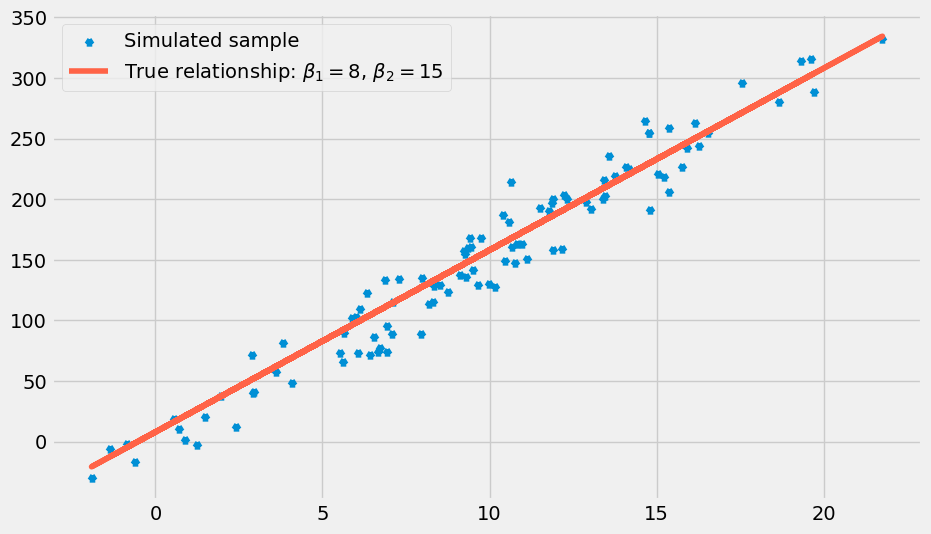

In [39]:
data = pd.DataFrame(dict(X=X, Y=Y, Y_hat=Y_hat))
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['X'], data['Y'], marker='1', label='Simulated sample')
ax.plot(data['X'], data['Y_hat'], color='tomato',\
        label=r'True relationship: $\beta_1={}$, $\beta_2={}$'.format(beta_1, beta_2))
ax.legend()
plt.show()

In [40]:
mu_1_prior, sigma_1_prior = 2, 3
mu_2_prior, sigma_2_prior = 20, 6
sigma_lh = np.std(Y)
tau_lh = 1/sigma_lh**2
tau_1_prior, tau_2_prior = 1/sigma_1_prior**2, 1/sigma_2_prior**2

In [41]:
mu_1_post, tau_1_post, sigma_1_post = mu_tau_1_post(tau_1_prior, mu_1_prior, 
                                                    mu_2_prior, tau_lh, Y, X, n)
mu_2_post, tau_2_post, sigma_2_post = mu_tau_2_post(tau_2_prior, mu_2_prior, 
                                                    mu_1_prior, tau_lh, Y, X, n)
betax_prior_1 = np.linspace(-15, 10, 100)
betax_prior_2 = np.linspace(0, 30, 100)

betay_prior_1 = sp.stats.norm.pdf(betax_prior_1, loc=mu_1_prior, scale=sigma_1_prior)
betay_prior_2 = sp.stats.norm.pdf(betax_prior_2, loc=mu_2_prior, scale=sigma_2_prior)

betax_post_1 = np.linspace(mu_1_post-3*sigma_1_post, mu_1_post+3*sigma_1_post, 100)
betax_post_2 = np.linspace(mu_2_post-sigma_2_post, mu_2_post+sigma_2_post, 100)

betay_post_1 = sp.stats.norm.pdf(betax_prior_1, loc=mu_1_post, scale=sigma_1_post)
betay_post_2 = sp.stats.norm.pdf(betax_prior_2, loc=mu_2_post, scale=sigma_2_post)

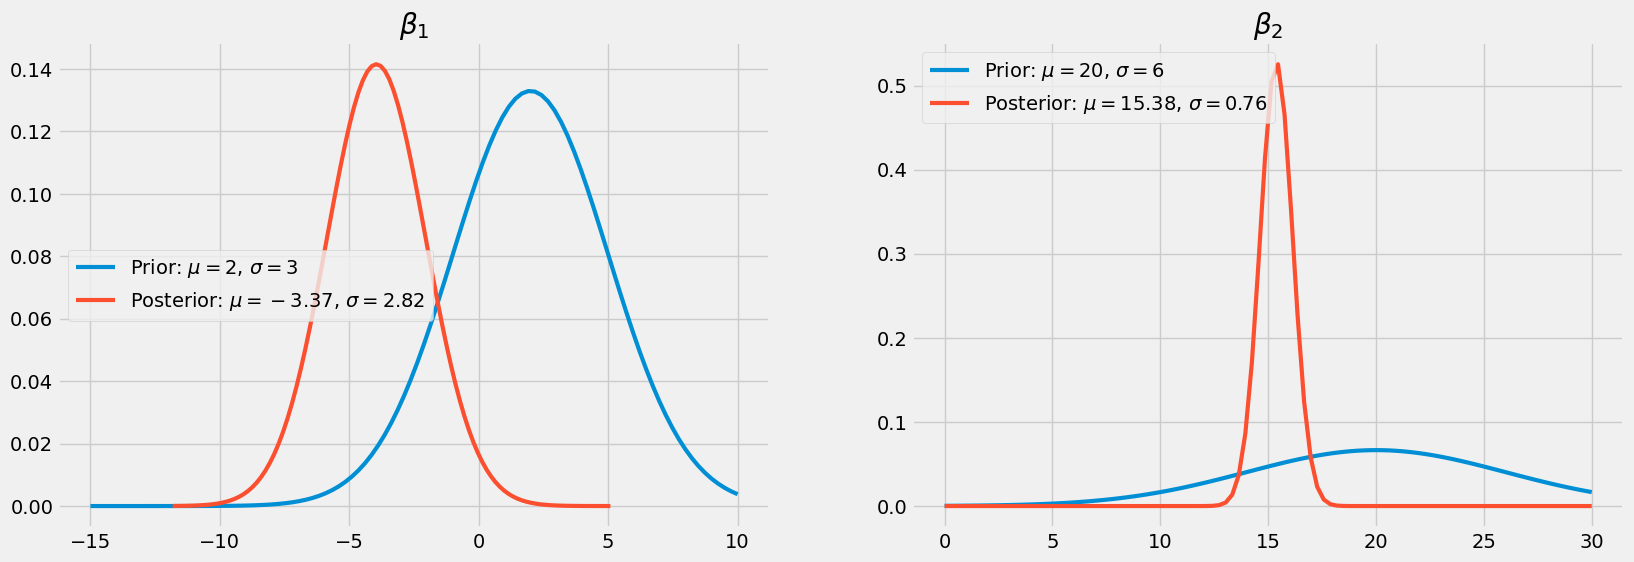

In [42]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)
ax[0].plot(betax_prior_1, betay_prior_1, lw = 3, label=r'Prior: $\mu={}$, $\sigma={}$'.format(mu_1_prior, sigma_1_prior))
ax[0].plot(betax_post_1, betay_post_1, lw=3, label=r'Posterior: $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu_1_post, sigma_1_post))
ax[0].set_title(r'$\beta_1$')
ax[1].plot(betax_prior_2, betay_prior_2, lw = 3, label=r'Prior: $\mu={}$, $\sigma={}$'.format(mu_2_prior, sigma_2_prior))
ax[1].plot(betax_prior_2, betay_post_2, lw=3, label=r'Posterior: $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu_2_post, sigma_2_post))
ax[1].set_title(r'$\beta_2$')
ax[0].legend()
ax[1].legend(loc='upper left')

# print('mu_1_post: {:.4f}'.format(mu_1_post))  depends on you if you'd like to print them
# print('tau_1_post: {:.10f}'.format(tau_1_post))
# print('sigma_1_post: {:.4f}'.format(sigma_1_post))
# print('')
# print('mu_2_post: {:.4f}'.format(mu_2_post))
# print('tau_2_post: {:.10f}'.format(tau_2_post))
# print('sigma_2_post: {:.4f}'.format(sigma_2_post))
plt.show()

In [43]:
with pm.Model() as linreg_model:  # model specifications in pymc are wrapped in a with-statement
    # Define priors
    beta1_hat = pm.Normal('beta1_hat', mu=8, sigma=3)
    beta2_hat = pm.Normal('beta2_hat', mu=15, sigma=.5)
    sigma = pm.Gamma('sigma', alpha=2, beta=1)

    # Define likelihood
    Y_hat = pm.Deterministic('Y_hat', beta1_hat+beta2_hat*X)
    Y_lh = pm.Normal('Y_lh', mu = Y_hat, sigma=sigma, observed=Y)
    
    # Sampling
    start = pm.Metropolis()
    trace = pm.sample(2000, cores=1, step=start, return_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1_hat]
>Metropolis: [beta2_hat]
>Metropolis: [sigma]


Output()

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pymc\step_meth
ods\metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 132 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


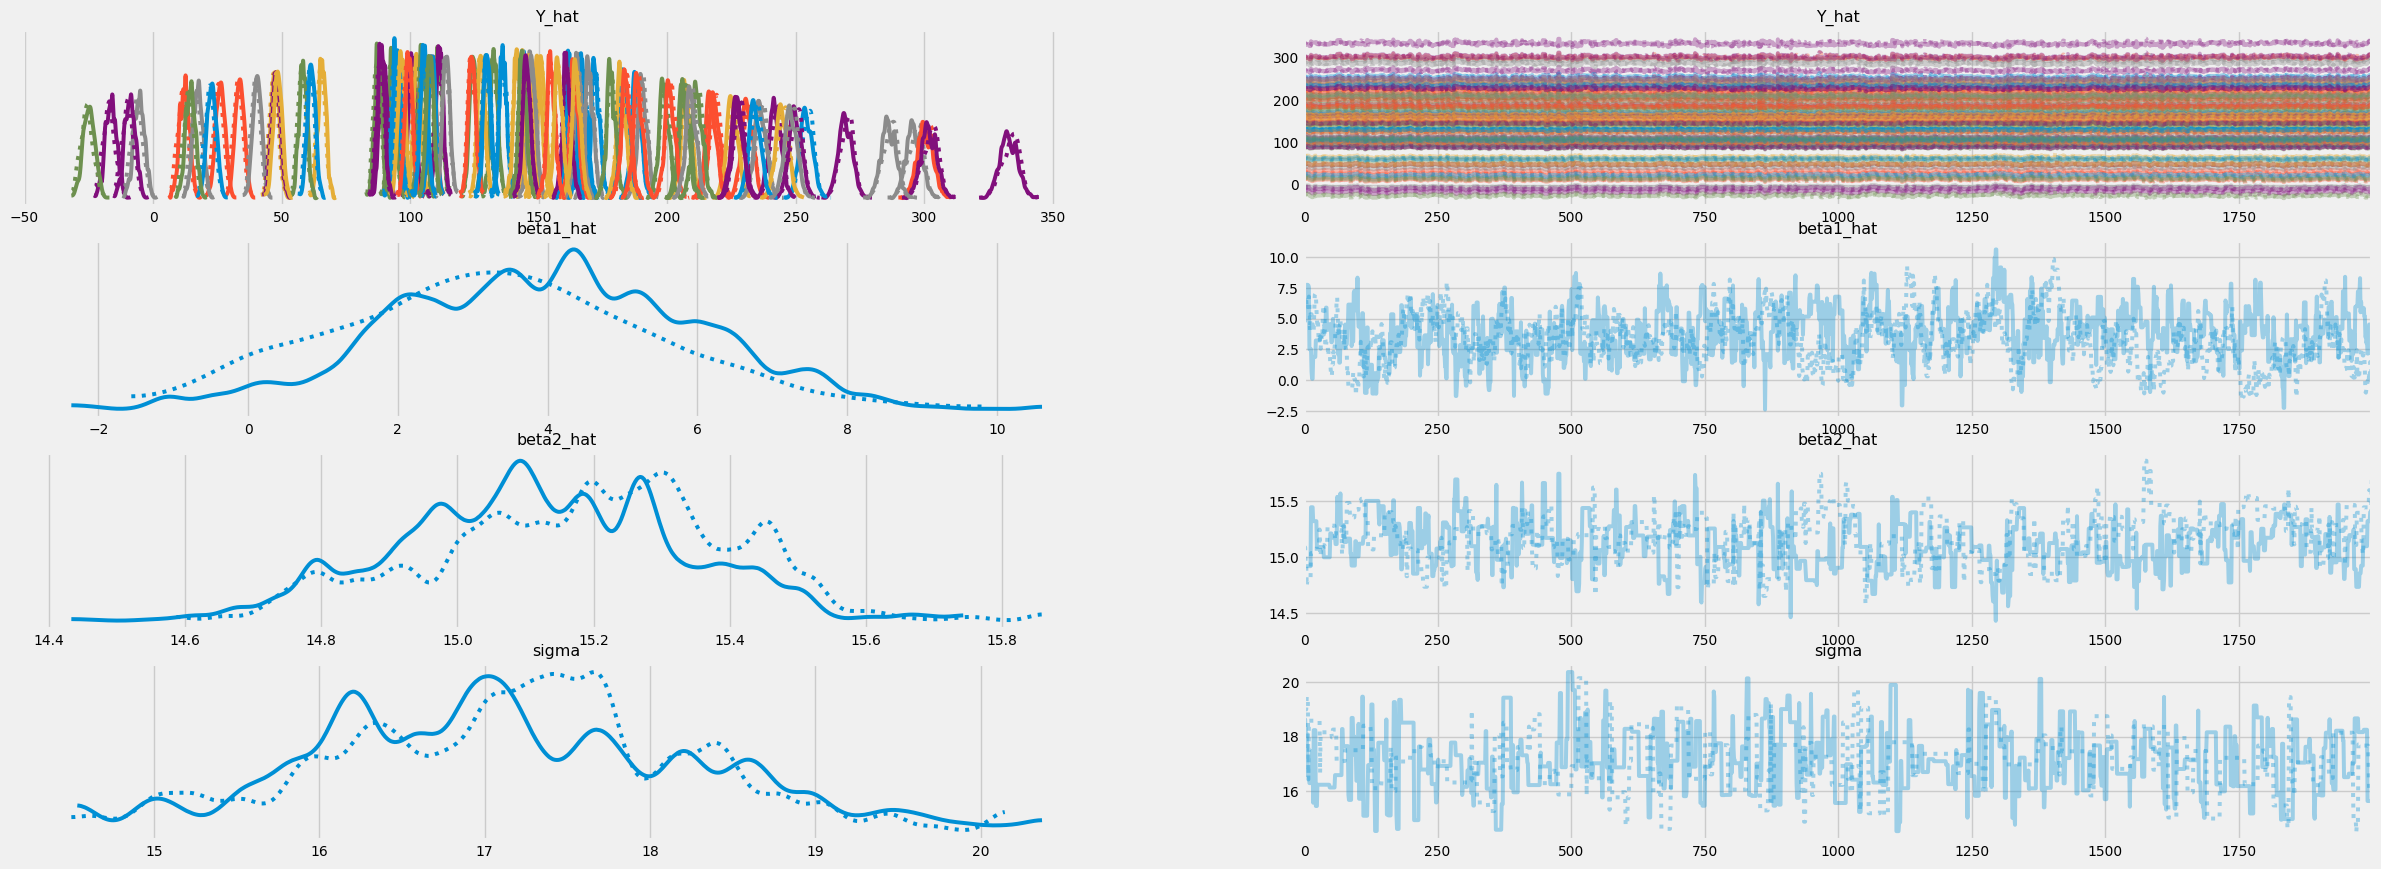

In [44]:
az.plot_trace(trace, figsize=(27, 10), compact=True); plt.show()

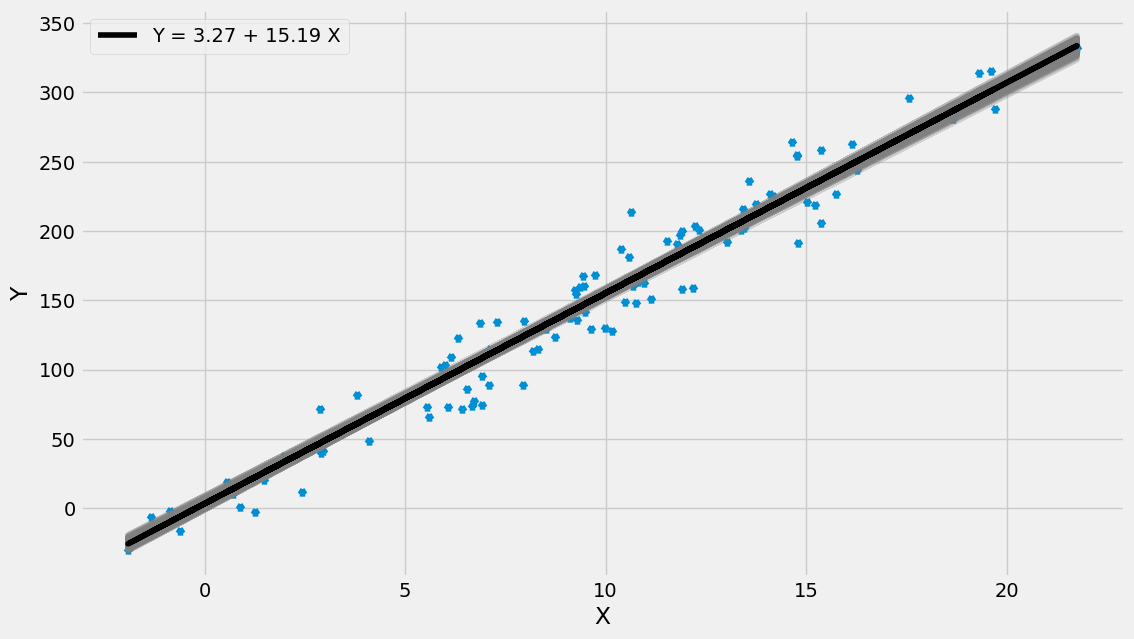

In [45]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(X, Y, marker = '1')

beta1_chain, beta2_chain = trace.posterior.beta1_hat.data[1], trace.posterior.beta2_hat.data[1]
beta1_m = np.mean(beta1_chain)
beta2_m = np.mean(beta2_chain)

draws = range(0, len(trace.posterior.beta1_hat.data[1]), 10)
ax.plot(X, beta1_chain[draws] + beta2_chain[draws]*X[:, np.newaxis], c='gray', alpha=0.3)

ax.plot(X, beta1_m + beta2_m * X, c='k',
         label=r'Y = {:.2f} + {:.2f} X'.format(beta1_m, beta2_m))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

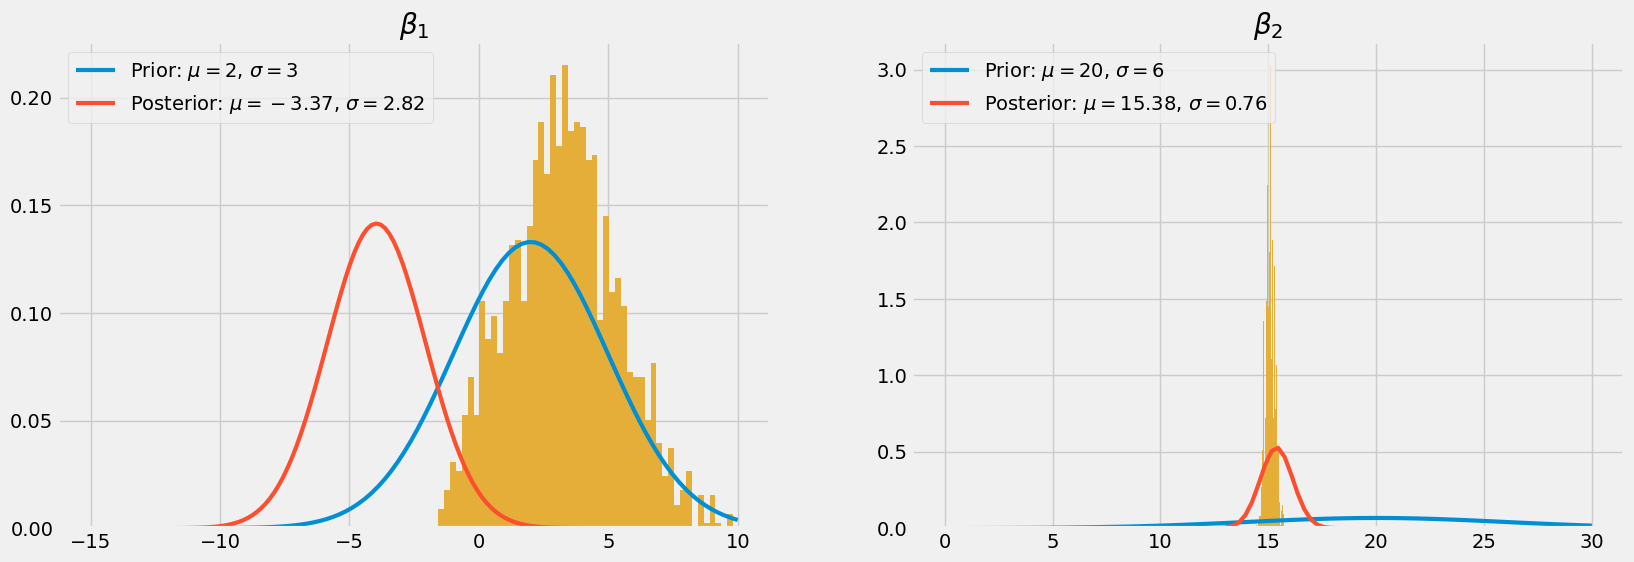

In [46]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)
ax[0].plot(betax_prior_1, betay_prior_1, lw = 3, label=r'Prior: $\mu={}$, $\sigma={}$'.format(mu_1_prior, sigma_1_prior))
ax[0].plot(betax_post_1, betay_post_1, lw=3, label=r'Posterior: $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu_1_post, sigma_1_post))
ax[0].hist(trace.posterior.beta1_hat.data[1], density=True, bins=50)
ax[0].set_title(r'$\beta_1$')


ax[1].plot(betax_prior_2, betay_prior_2, lw = 3, label=r'Prior: $\mu={}$, $\sigma={}$'.format(mu_2_prior, sigma_2_prior))
ax[1].plot(betax_prior_2, betay_post_2, lw=3, label=r'Posterior: $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu_2_post, sigma_2_post))
ax[1].set_title(r'$\beta_2$')
ax[1].hist(trace.posterior.beta2_hat.data[0], density=True, bins=50)
ax[0].legend()
ax[1].legend(loc='upper left')

plt.show()

By plotting the scatter plot of simulated $\beta_1$ and $\beta_2$, we actually can see the joint of posterior of them, which is by default a ellipsoid.

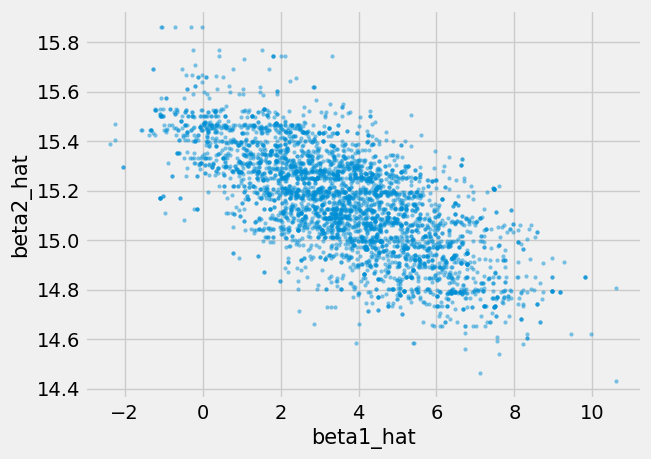

In [47]:
az.plot_pair(trace, var_names=['beta1_hat', 'beta2_hat'], scatter_kwargs={'alpha': 0.5}); plt.show()

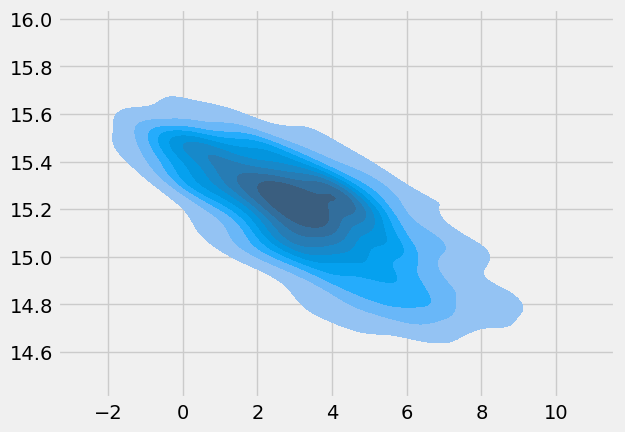

In [48]:
sns.kdeplot(x = trace.posterior.beta1_hat.data[1], y= trace.posterior.beta2_hat.data[1], fill=True); plt.show()

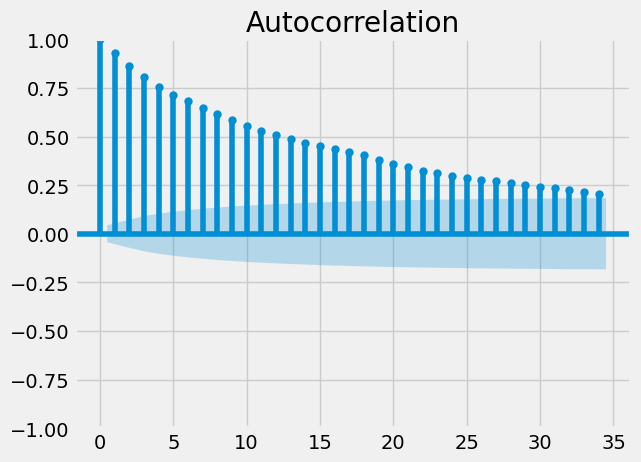

In [49]:
x = plot_acf(trace.posterior.beta1_hat.data[1])

## <font face="gotham" color="orange"> An Example of Apartment Price </font>

In [50]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', 'CN_Cities_house_price')

In [51]:
df.head()

,cities,house_price,salary
0,Shenzhen,87957,64878
1,Beijing,64721,69434
2,Shanghai,59072,72232
3,Xiamen,49803,58140
4,Guangzhou,39851,68304


The model to fit the data ill be exactly as we derived above, i.e.
$$
Y_i=\beta_1+\beta_2X_i+u_i\qquad i = 1, 2, ..., n
$$

This simple model aims to explain the influence of salary on apartment price per square meter. The $\beta_1$ doesn't have much meaning in the model, literally it means the apartment price when salary equals $0$. However $\beta_2$ has a concrete meaning that how much apartment price can raise based on every one yuan increase in average salary.

We can choose to elicit priors' hyperparameters for $\beta_1$ and $\beta_2$ as 
$$
\mu_1 = 1000\\
\sigma_1 = 200 \qquad h_1 = \frac{1}{\sigma_1^2}\\
\mu_2 = 1.5\\
\sigma_2 = .3 \qquad h_2 = \frac{1}{\sigma_2^2}\\
$$

In [52]:
Y, X = df['house_price'], df['salary']

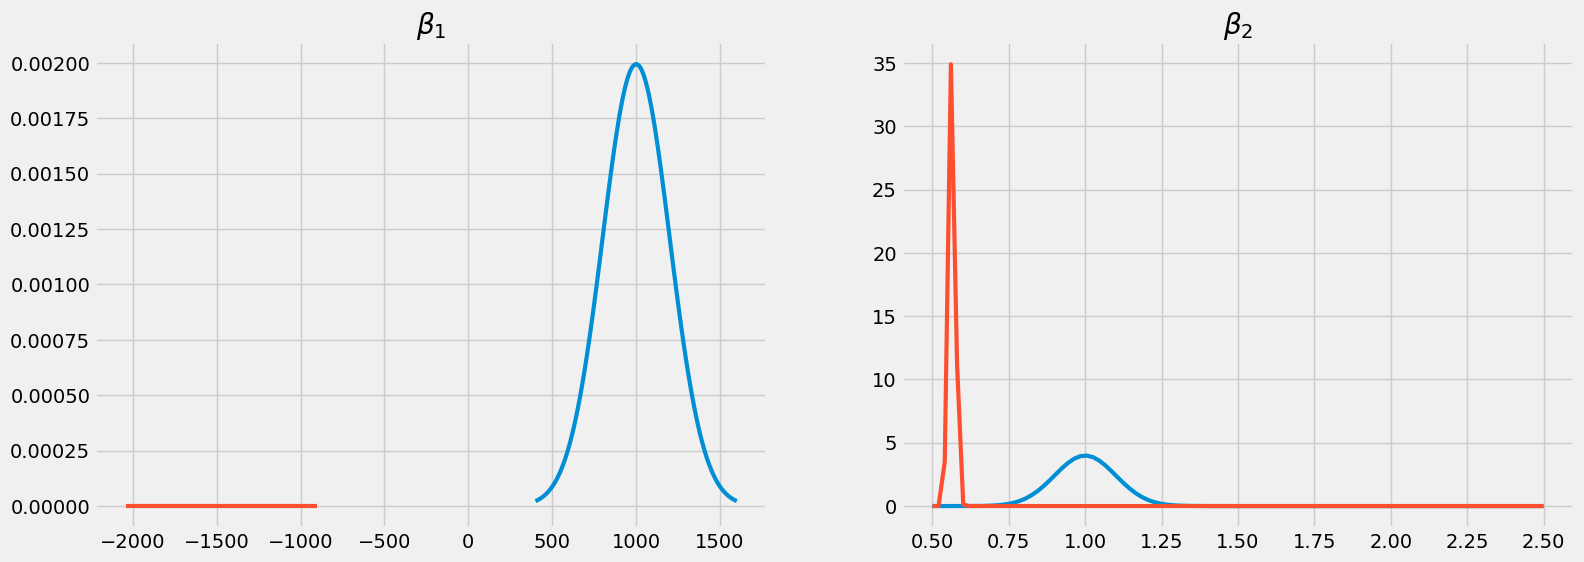

mu_1_post: -1473.2840
tau_1_post: 0.0000277778
sigma_1_post: 189.7367

mu_2_post: 0.5640
tau_2_post: 8442.1727574444
sigma_2_post: 0.0109


In [53]:
mu_1_prior, sigma_1_prior = 1000, 200
mu_2_prior, sigma_2_prior = 1, .1
sigma_lh = 3000
tau_lh = 1/sigma_lh**2
tau_1_prior, tau_2_prior = 1/sigma_1_prior**2, 1/sigma_2_prior**2

betax_prior_1 = np.linspace(400, 1600, 100)
betax_prior_2 = np.linspace(.5, 2.5, 100)

betay_prior_1 = sp.stats.norm.pdf(betax_prior_1, loc=mu_1_prior, scale=sigma_1_prior)
betay_prior_2 = sp.stats.norm.pdf(betax_prior_2, loc=mu_2_prior, scale=sigma_2_prior)
n = len(X)

# use functions to calculate posterior hyperparameters
mu_1_post, tau_1_post, sigma_1_post = mu_tau_1_post(tau_1_prior, mu_1_prior, mu_2_prior, tau_lh, Y, X, n)
mu_2_post, tau_2_post, sigma_2_post = mu_tau_2_post(tau_2_prior, mu_2_prior, mu_1_prior, tau_lh, Y, X, n)

betay_post_1 = sp.stats.norm.pdf(betax_prior_1, loc=mu_1_post, scale=sigma_1_post)
betay_post_2 = sp.stats.norm.pdf(betax_prior_2, loc=mu_2_post, scale=sigma_2_post)


fig, ax = plt.subplots(figsize=(17, 6), nrows=1, ncols=2)

betax_post_1 = np.linspace(mu_1_post-3*sigma_1_post, mu_1_post+3*sigma_1_post, 100)
#betax_post_2 = np.linspace(mu_2_post-sigma_2_post, mu_2_post+sigma_2_post, 100)

ax[0].plot(betax_prior_1, betay_prior_1, lw = 3)
ax[0].plot(betax_post_1, betay_post_1, lw=3)
ax[0].set_title(r'$\beta_1$')
ax[1].plot(betax_prior_2, betay_prior_2, lw = 3)
ax[1].plot(betax_prior_2, betay_post_2, lw=3)
ax[1].set_title(r'$\beta_2$')

plt.show()

print('mu_1_post: {:.4f}'.format(mu_1_post))
print('tau_1_post: {:.10f}'.format(tau_1_post))
print('sigma_1_post: {:.4f}'.format(sigma_1_post))
print('')
print('mu_2_post: {:.4f}'.format(mu_2_post))
print('tau_2_post: {:.10f}'.format(tau_2_post))
print('sigma_2_post: {:.4f}'.format(sigma_2_post))

In [54]:
model = smf.ols(formula='house_price ~ salary', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            house_price   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     13.21
Date:                Sat, 08 Jun 2024   Prob (F-statistic):            0.00139
Time:                        22:24:05   Log-Likelihood:                -274.08
No. Observations:                  25   AIC:                             552.2
Df Residuals:                      23   BIC:                             554.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.918e+04   1.66e+04     -1.758      0.0

In [55]:
ols_coeff = pd.DataFrame(results.params, columns =['OLS estimates'])
ols_coeff

,OLS estimates
Intercept,-29181.169815
salary,1.100985


In [56]:
with pm.Model() as model:  # model specifications in pymc are wrapped in a with-statement
    # Define priors
    beta1_hat = pm.Normal('beta1_hat', mu=0, sigma=3)
    beta2_hat = pm.Normal('beta2_hat', mu=0, sigma=.5)
    sigma = pm.Gamma('sigma', alpha=2, beta=1)

    # Define likelihood
    Y_lh = pm.Normal('Y_lh', mu = beta1_hat + beta2_hat * X.values, sigma=sigma, observed=Y.values)
    
    # Sampling
    start = pm.Metropolis()
    trace = pm.sample(10000, cores=1, step=start, return_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1_hat]
>Metropolis: [beta2_hat]
>Metropolis: [sigma]


Output()

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pymc\step_meth
ods\metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 157 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


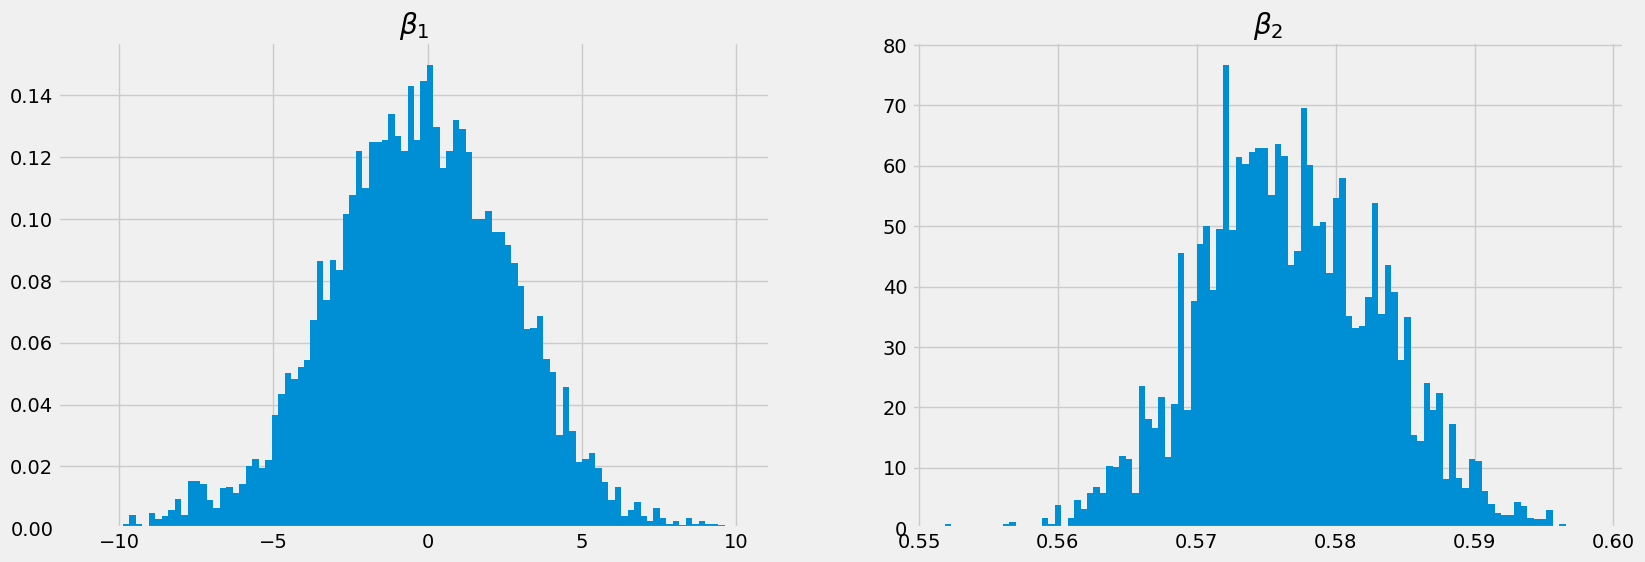

In [57]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)
ax[0].hist(trace.posterior.beta1_hat.data[1], density=True, bins=100)
ax[0].set_title(r'$\beta_1$')
ax[1].set_title(r'$\beta_2$')
ax[1].hist(trace.posterior.beta2_hat.data[0], density=True, bins=100)

plt.show()

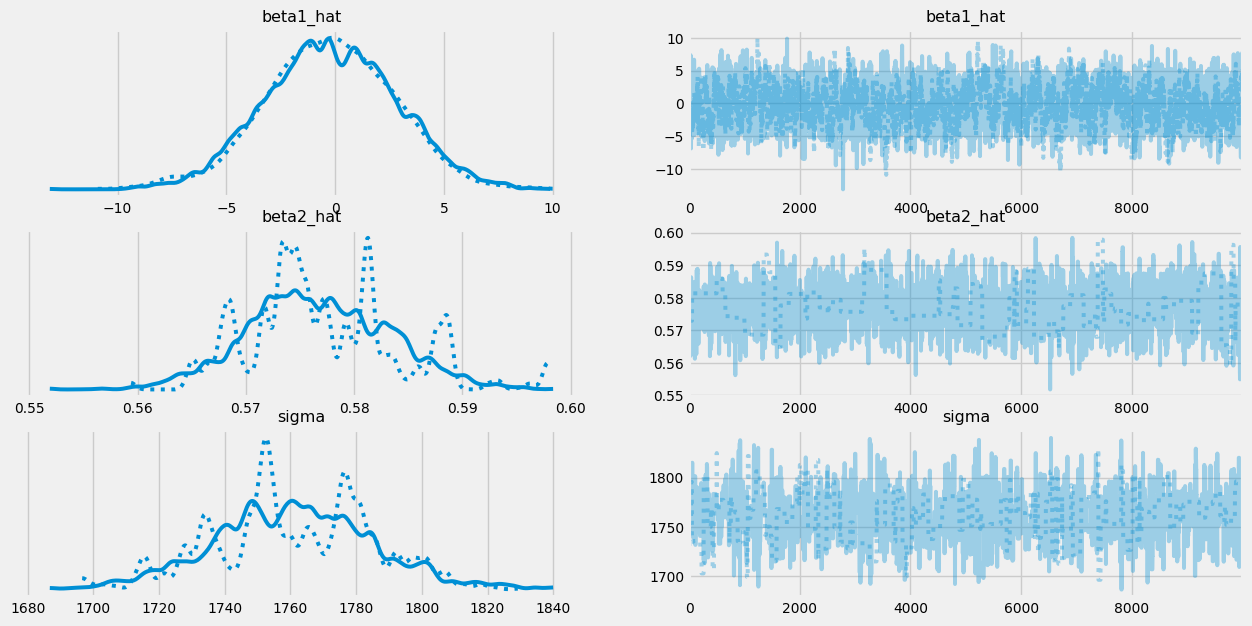

In [58]:
az.plot_trace(trace, figsize=(14, 7)); plt.show()

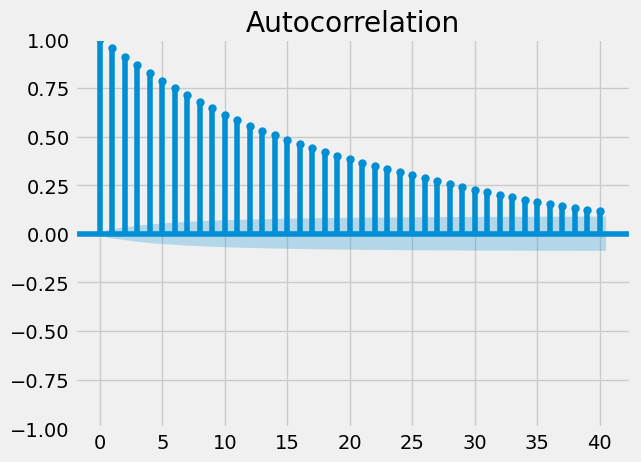

In [59]:
x = plot_acf(trace.posterior.beta1_hat.data[1])

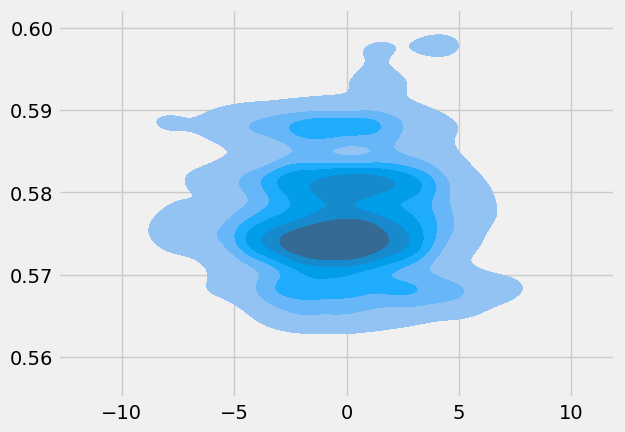

In [60]:
sns.kdeplot(x = trace.posterior.beta1_hat.data[1], y= trace.posterior.beta2_hat.data[1],levels=7, fill=True); plt.show()

In [61]:
idx = range(0, len(trace.posterior.beta1_hat.data[1]), 10)
beta1_hat_mcmc_grid = trace.posterior.beta1_hat.data[1][idx]
beta2_hat_mcmc_grid = trace.posterior.beta2_hat.data[1][idx]

In [62]:
X = pd.Series.to_numpy(X)

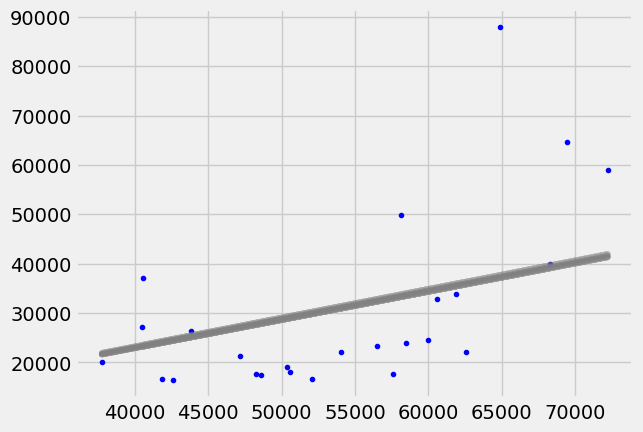

In [63]:

plt.plot(X, Y, 'b.');
idx = np.array(range(0, len(trace.posterior.beta1_hat.data[1]), 1000))
plt.plot(X, trace.posterior.beta1_hat.data[1][idx] + trace.posterior.beta2_hat.data[1][idx] * X[:,np.newaxis], c='gray', alpha=0.3);


## <font face="gotham" color="orange"> Polynomial Regression </font>

Polynomial regressions are essential linear regressions, because the power taken on the variables not the parameters.

In [64]:
beta_1, beta_2, beta_3 = 2, 5, -3 
n = 100
X = np.linspace(1, 5, n)
u = np.random.randn(n)*5
Y_mu = beta_1 + beta_2*X + beta_3*X**2
Y = Y_mu + u

In [65]:
with pm.Model() as model_poly:
    beta_1 = pm.Normal('beta_1', mu=1, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=2, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=3, sigma=1)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = beta_1 + beta_2 * X + beta_3 * X**2

    Y_pred = pm.Normal('Y_pred', mu=mu, sigma=sigma, observed=Y)

    trace_poly = pm.sample(1000, cores=1, return_inferencedata=True) # return a MultiTrace object

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_1, beta_2, beta_3, sigma]


Output()

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\scala
r\basic.py:3204: RuntimeWarning: overflow encountered in scalar multiply
  return x * x

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\scala
r\basic.py:3098: RuntimeWarning: overflow encountered in exp
  return np.exp(x)

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\pytensor\scala
r\basic.py:2004: RuntimeWarning: invalid value encountered in divide
  return x / y

Output()

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\weijie-chen-Vyy5-xRM-py3.12\Lib\site-packages\numpy\core\fro
mnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 631 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


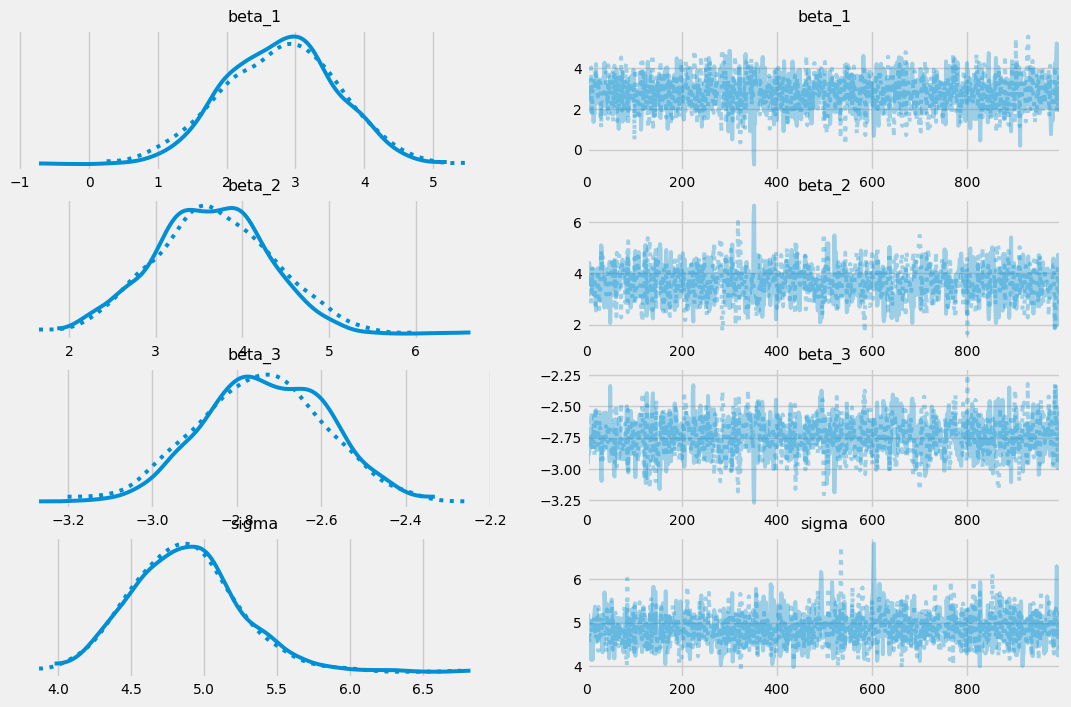

In [66]:
az.plot_trace(trace_poly); plt.show()

In [67]:
beta1_hat_mu = np.mean(trace_poly.posterior.beta_1.values[0])
beta2_hat_mu = np.mean(trace_poly.posterior.beta_2.values[0])
beta3_hat_mu = np.mean(trace_poly.posterior.beta_3.values[0])
Y_hat = beta1_hat_mu + beta2_hat_mu*X + beta3_hat_mu*X**2

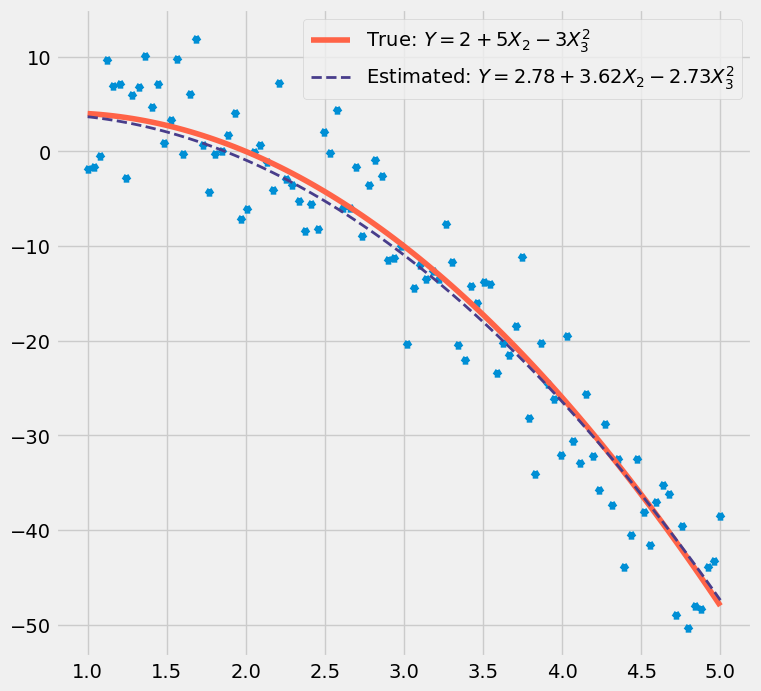

In [68]:
beta_1, beta_2, beta_3 = 2, 5, -3 
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X, Y_mu, color='tomato', label=r'True: $Y={}+{}X_2{}X_3^2$'.format(beta_1, beta_2, beta_3))
ax.plot(X, Y_hat, color='DarkSlateBlue', lw=2, ls='--', 
        label=r'Estimated: $Y={:.2f}+{:.2f}X_2{:.2f}X_3^2$'.format(beta1_hat_mu, beta2_hat_mu, beta3_hat_mu))
ax.scatter(X, Y, marker='1')
ax.legend()
plt.show()